In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [44]:
import pickle # for saving objects

import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px # for nice plotting

import warnings

from wordcloud import WordCloud


import math

from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer

from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM

from sklearn.decomposition import LatentDirichletAllocation # LDA implementation

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [2]:
with open("/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/qatar/qatar_data/qatar_data_df_preprocessed.pkl", "rb") as fp:
    qatar_data_df = pickle.load(fp)

In [3]:
qatar_data_df.head()

0                                                  1  \
0  18 January 2023  From 172 goals scored, to five billion people ...   
1  12 January 2023  In between 64 matches and 29 days of dramatic ...   
2  11 January 2023  As fans celebrated and cheered for their favou...   
3   5 January 2023  For B4Development (B4D) â a Qatar 2022 legac...   
4   3 January 2023  In 2022, the Generation Amazing Foundation (GA...   

                                                   3  
0  [goals, scored, five, billion, people, engaged...  
1  [matches, days, dramatic, action, field, milli...  
2  [fans, celebrated, cheered, favourite, players...  
3  [bdevelopment, bd, , legacy, project, launch...  
4  [generation, amazing, foundation, ga, , supr...

In [4]:
# as our preprocessed data is already tokenized
# therefore, we need to make them strings again...

def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele+" "
    return str1

qatar_data_df[4] = qatar_data_df[3] # new column, for now a copy of tokenized and preprocessed texts
for i in range(0,len(qatar_data_df)):
    qatar_data_df[4][i] = listToString(qatar_data_df[4][i])

qatar_data_df

0                                                  1  \
0     18 January 2023  From 172 goals scored, to five billion people ...   
1     12 January 2023  In between 64 matches and 29 days of dramatic ...   
2     11 January 2023  As fans celebrated and cheered for their favou...   
3      5 January 2023  For B4Development (B4D) â a Qatar 2022 legac...   
4      3 January 2023  In 2022, the Generation Amazing Foundation (GA...   
..                ...                                                ...   
152  6 September 2022  QNB Group â the largest financial institutio...   
153  5 September 2022  The FIFA World Cup Qatar 2022â¢ is set to fea...   
154  4 September 2022  Lusail City keenly illustrates Qatarâs visio...   
155  3 September 2022  Over 16,000 volunteers, staff and guests come ...   
156     21 April 2021  Qatar will provide safe, reliable and accessib...   

                                                     3  \
0    [goals, scored, five, billion, people, engaged...   
1    [matches, days, dramatic, action, field, milli...   
2    [fans, celebrated, cheered, favourite, players...   
3    [bdevelopment, bd, , legacy, project, launch...   
4    [generation, amazing, foundation, ga, , supr...   
..                                                 ...   
152  [qnb, group, , largest, financial, instituti...   
153  [¢, set, feature, teams, appeared, footballâ...   
154  [lusail, city, keenly, illustrates, qatarâ, ...   
155  [volunteers, staff, guests, come, together, lu...   
156  [provide, safe, reliable, accessible, transpor...   

                                                     4  
0    goals scored five billion people engaged host ...  
1    matches days dramatic action field millions fa...  
2    fans celebrated cheered favourite players pitc...  
3    bdevelopment bd  legacy project launched sup...  
4    generation amazing foundation ga  supreme co...  
..                                                 ...  
152  qnb group  largest financial institution mid...  
153  ¢ set feature teams appeared footballâ show...  
154  lusail city keenly illustrates qatarâ vision...  
155  volunteers staff guests come together lusail s...  
156  provide safe reliable accessible transportatio...  

[157 rows x 4 columns]

# Latent Dirichlet Allocation (LDA)

In [5]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tf_vectorizer = CountVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(qatar_data_df[4]), #filtering with document frequency
                                tokenizer = tokenizer.tokenize
)
tf = tf_vectorizer.fit_transform(qatar_data_df[4])
tf_feature_names = tf_vectorizer.get_feature_names()

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                   max_df = 0.75, #filtering with document frequency
                                   min_df = 5/len(qatar_data_df[4]), #filtering with document frequency
                                   tokenizer = tokenizer.tokenize
)
tfidf = tfidf_vectorizer.fit_transform(qatar_data_df[4])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [6]:
lda = LatentDirichletAllocation(
                                doc_topic_prior = None,
                                # prior theta/alpha
                                # i.e. document - topic distribution;
                                # None means 1/n_components

                                topic_word_prior = None,
                                # prior beta/eta
                                # i.e. topic - word distribution

                                learning_method = 'online',
                                # method used in fit();
                                # 'batch' stands for variational Bayes method
                                # 'online' stands for using mini-batch
                                # on data in every EM iteration;
                                # in case of a huge dataset, 'online'
                                # is recommended as a faster option

                                learning_decay = 0.7,
                                # if using 'online' learning method,
                                # this indicates bini-batch size

                                learning_offset = 50.0,
                                # this parameter downweights early iterations
                                # in online learning

                                max_iter = 150,
                                # iterations in fit()

                                batch_size = 128,
                                # number of documnets to be used in a batch
                                # in 'online' learning

                                evaluate_every = -1,
                                # if ones want to evaluate perplexity
                                # every x iterations; negative number
                                # means no perplexity evaluation and
                                # procceding

                                total_samples = 1000000.0,
                                # total number of documents for partial_fit()
                                # method

                                perp_tol = 0.1,
                                # perplexity tolerance if we use
                                # evaluate_every option

                                mean_change_tol = 0.001,
                                # stopping tolerance for E-step in EM

                                max_doc_update_iter = 100,
                                # max number of iterations for E-step in EM

                                n_jobs = None,
                                # number of jobs to be done in E-step

                                verbose = 1,
                                # whether to print some parameters

                                random_state = 123
)

lda.fit(tf)

iteration: 1 of max_iter: 150
iteration: 2 of max_iter: 150
iteration: 3 of max_iter: 150
iteration: 4 of max_iter: 150
iteration: 5 of max_iter: 150
iteration: 6 of max_iter: 150
iteration: 7 of max_iter: 150
iteration: 8 of max_iter: 150
iteration: 9 of max_iter: 150
iteration: 10 of max_iter: 150
iteration: 11 of max_iter: 150
iteration: 12 of max_iter: 150
iteration: 13 of max_iter: 150
iteration: 14 of max_iter: 150
iteration: 15 of max_iter: 150
iteration: 16 of max_iter: 150
iteration: 17 of max_iter: 150
iteration: 18 of max_iter: 150
iteration: 19 of max_iter: 150
iteration: 20 of max_iter: 150
iteration: 21 of max_iter: 150
iteration: 22 of max_iter: 150
iteration: 23 of max_iter: 150
iteration: 24 of max_iter: 150
iteration: 25 of max_iter: 150
iteration: 26 of max_iter: 150
iteration: 27 of max_iter: 150
iteration: 28 of max_iter: 150
iteration: 29 of max_iter: 150
iteration: 30 of max_iter: 150
iteration: 31 of max_iter: 150
iteration: 32 of max_iter: 150
iteration: 33 of 

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=150, random_state=123, verbose=1)

In [7]:
lda.perplexity(tf)

1044.250026672777

In [8]:
for index, component in enumerate(lda.components_): #taking model's components, i.e. P(w|z)
    zipped = zip(tf_vectorizer.get_feature_names(), component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['fans', 'stadium', 'cupâ', 'first', 'host', 'group', 'also', 'lusail', 'said', 'during']
Topic 1:  ['ambassadors', 'work', 'first', 'cupâ', 'part', 'like', 'legacy', 'working', 'sc', 'bid']
Topic 2:  ['stadium', 'fans', 'part', 'people', 'said', 'sc', 'during', 'one', 'also', 'itâ']
Topic 3:  ['legacy', 'sc', 'delivery', 'generation', 'amazing', 'committee delivery legacy', 'delivery legacy', 'supreme committee delivery', 'supreme', 'committee delivery']
Topic 4:  ['match', 'fan', 'first', 'set', 'fans', 'around', 'arab', 'argentina', 'training', 'team']
Topic 5:  ['public', 'legacy', 'fans', 'first', 'doha', 'said', 'ambassadors', 'metro', 'committee delivery legacy', 'part']
Topic 6:  ['stadium', 'fans', 'during', 'also', 'cupâ', 'audio descriptive', 'descriptive', 'said', 'doha', 'people']
Topic 7:  ['said', 'fans', 'one', 'every day', 'people', 'every', 'the', 'lusail stadium', 'during', 'part']
Topic 8:  ['hayya', 'fans', 'fan', 'pm', 'transport', 'available', 'public',

In [9]:
lda = LatentDirichletAllocation(
                                doc_topic_prior = None,
                                # prior theta/alpha
                                # i.e. document - topic distribution;
                                # None means 1/n_components

                                topic_word_prior = None,
                                # prior beta/eta
                                # i.e. topic - word distribution

                                learning_method = 'online',
                                # method used in fit();
                                # 'batch' stands for variational Bayes method
                                # 'online' stands for using mini-batch
                                # on data in every EM iteration;
                                # in case of a huge dataset, 'online'
                                # is recommended as a faster option

                                learning_decay = 0.7,
                                # if using 'online' learning method,
                                # this indicates bini-batch size

                                learning_offset = 50.0,
                                # this parameter downweights early iterations
                                # in online learning

                                max_iter = 150,
                                # iterations in fit()

                                batch_size = 128,
                                # number of documnets to be used in a batch
                                # in 'online' learning

                                evaluate_every = -1,
                                # if ones want to evaluate perplexity
                                # every x iterations; negative number
                                # means no perplexity evaluation and
                                # procceding

                                total_samples = 1000000.0,
                                # total number of documents for partial_fit()
                                # method

                                perp_tol = 0.1,
                                # perplexity tolerance if we use
                                # evaluate_every option

                                mean_change_tol = 0.001,
                                # stopping tolerance for E-step in EM

                                max_doc_update_iter = 100,
                                # max number of iterations for E-step in EM

                                n_jobs = None,
                                # number of jobs to be done in E-step

                                verbose = 1,
                                # whether to print some parameters

                                random_state = 123
)

lda.fit(tfidf)

iteration: 1 of max_iter: 150
iteration: 2 of max_iter: 150
iteration: 3 of max_iter: 150
iteration: 4 of max_iter: 150
iteration: 5 of max_iter: 150
iteration: 6 of max_iter: 150
iteration: 7 of max_iter: 150
iteration: 8 of max_iter: 150
iteration: 9 of max_iter: 150
iteration: 10 of max_iter: 150
iteration: 11 of max_iter: 150
iteration: 12 of max_iter: 150
iteration: 13 of max_iter: 150
iteration: 14 of max_iter: 150
iteration: 15 of max_iter: 150
iteration: 16 of max_iter: 150
iteration: 17 of max_iter: 150
iteration: 18 of max_iter: 150
iteration: 19 of max_iter: 150
iteration: 20 of max_iter: 150
iteration: 21 of max_iter: 150
iteration: 22 of max_iter: 150
iteration: 23 of max_iter: 150
iteration: 24 of max_iter: 150
iteration: 25 of max_iter: 150
iteration: 26 of max_iter: 150
iteration: 27 of max_iter: 150
iteration: 28 of max_iter: 150
iteration: 29 of max_iter: 150
iteration: 30 of max_iter: 150
iteration: 31 of max_iter: 150
iteration: 32 of max_iter: 150
iteration: 33 of 

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=150, random_state=123, verbose=1)

In [10]:
for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['stadium', 'group', 'venue', 'sustainability', 'stadiumâ', 'design', 'janoub', 'project', 'group december', 'construction']
Topic 1:  ['hayya', 'card', 'hayya card', 'ahmad bin', 'bin', 'pm', 'ali stadium', 'bin ali stadium', 'bin ali', 'ahmad bin ali']
Topic 2:  ['people', 'accessibility', 'disabled', 'sc', 'stadium', 'the', 'tell us', 'relations', 'training', 'accessible']
Topic 3:  ['legacy', 'sc', 'volunteers', 'generation amazing', 'volunteer', 'generation', 'training', 'delivery legacy sc', 'legacy sc', 'amazing']
Topic 4:  ['fans', 'lusail', 'first', 'cupâ', 'stadium', 'said', 'during', 'host', 'fan', 'arab']
Topic 5:  ['lusail', 'public', 'sustainability', 'benefits', 'seen', 'fans', 'th', 'accommodation', 'manager', 'doha']
Topic 6:  ['available', 'hayya', 'phase', 'due', 'per', 'non', 'hayya card holders', 'pm', 'card holders', 'holders']
Topic 7:  ['every day', 'thawadi', 'lusail stadium', 'spoke', 'central doha', 'one', 'sporting events', 'legacy sc', 'de', 'kick

### Finding optimal number of topics in LDA

In [11]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [12]:
measures_specific = []

for n_topics in range(2,51,1):

    print('Trying parameters:', n_topics)

    lda = LatentDirichletAllocation(n_components = n_topics,
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 50,
                                    random_state = 123)

    lda.fit(tf)

    avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

In [13]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_df_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

save_object(measures_specific_df_lda, '/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/qatar/qatar_data/measures_specific_df_lda_qatar.pkl')

In [14]:
with open("/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/qatar/qatar_data/measures_specific_df_lda_qatar.pkl", "rb") as fp:
    measures_specific_df_lda = pickle.load(fp)

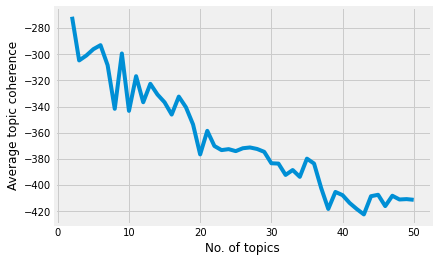

In [15]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_df_lda['n_topics'],measures_specific_df_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [16]:
measures_specific_df_lda.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

avg_coherence  n_topics
0     -271.359853         2
4     -293.077311         6
3     -296.129992         5
7     -299.434453         9
2     -301.031984         4
1     -304.768894         3
5     -308.402653         7
9     -316.776530        11
11    -322.625559        13

### Let us try optimizing the number of topics for LDA with TfidfVectorizer() applied.

In [17]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

measures_specific = []

for n_topics in range(2,51,1):

    print('Trying parameters:', n_topics)

    lda = LatentDirichletAllocation(n_components = n_topics,
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 100,
                                    random_state = 123)

    lda.fit(tfidf)

    avg_coherence = get_average_topic_coherence(tfidf, lda.components_, 25)

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

In [18]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_tfidf_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

save_object(measures_specific_tfidf_lda, '/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/qatar/qatar_data/measures_specific_tfidf_lda_qatar.pkl')

In [19]:
with open("/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/qatar/qatar_data/measures_specific_tfidf_lda_qatar.pkl", "rb") as fp:
    measures_specific_tfidf_lda = pickle.load(fp)

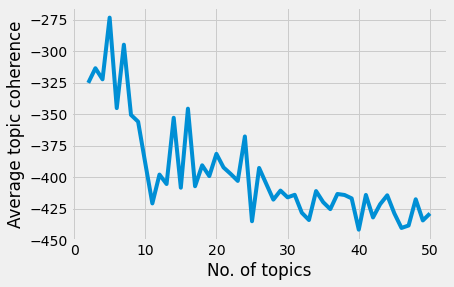

In [20]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_tfidf_lda['n_topics'],measures_specific_tfidf_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [22]:
measures_specific_tfidf_lda.sort_values('avg_coherence', ascending = False).iloc[0:50,:]

avg_coherence  n_topics
3     -273.293210         5
5     -294.802306         7
1     -313.490350         3
2     -322.303416         4
0     -325.120993         2
4     -345.162016         6
14    -345.613128        16
6     -350.555119         8
12    -352.852169        14
7     -355.926850         9
22    -367.680975        24
18    -381.481712        20
8     -388.663264        10
16    -390.596278        18
19    -392.305149        21
24    -392.685675        26
20    -397.404524        22
10    -397.953447        12
17    -399.166579        19
21    -402.983580        23
25    -405.310673        27
11    -405.462891        13
15    -407.243009        17
13    -408.394349        15
27    -410.682047        29
32    -411.061292        34
35    -413.362217        37
29    -414.033378        31
39    -414.112095        41
36    -414.170543        38
42    -414.432170        44
28    -416.046161        30
37    -416.862475        39
46    -417.569958        48
26    -417.867765        28
33    -419.885275        35
9     -420.884257        11
41    -421.513815        43
34    -425.422124        36
30    -428.298722        32
43    -428.810529        45
48    -428.883453        50
40    -432.015258        42
31    -434.057151        33
47    -434.411507        49
23    -435.022825        25
45    -438.418841        47
44    -440.357666        46
38    -441.744608        40

### Optimal $\alpha$ and $\beta$ parameters

In [23]:
lda = LatentDirichletAllocation(n_components = 29,
                                doc_topic_prior = 0.001, # try: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25
                                topic_word_prior = 0.001, # try: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 50,
                                random_state = 123)
lda.fit(tf)

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['fans', 'stadium', 'cupâ', 'first', 'during', 'also', 'said', 'hayya', 'host', 'lusail']
Topic 1:  ['cupâ', 'first', 'work', 'like', 'legacy', 'stadium', 'win', 'working', 'middle', 'new']
Topic 2:  ['fans', 'part', 'stadium', 'people', 'one', 'said', 'sc', 'the', 'also', 'festivalâ']
Topic 3:  ['workers', 'rights', 'ensure', 'continued', 'government', 'security', 'human', 'sc', 'cupâ', 'contractors']
Topic 4:  ['match', 'exhibition', 'set', 'training', 'looking forward', 'argentina', 'despite', 'souq', 'team', 'studying']
Topic 5:  ['first', 'stars', 'th', 'seen', 'among', 'footballâ', 'edition cupâ', 'once in lifetime', 'wonderful', 'fans']
Topic 6:  ['stadium', 'fans', 'also', 'accommodation', 'during', 'group', 'cupâ', 'people', 'hayya', 'first']
Topic 7:  ['every day', 'one', 'thawadi', 'lusail stadium', 'kick off', 'central doha', 'spoke', 'fans', 'legacy sc', 'canâ']
Topic 8:  ['fans', 'first', 'including', 'doha', 'corniche', 'arab', 'work', 'cupâ', 'central', 'suppo

In [24]:
params = []
for alpha in [0.0001, 0.001, 0.01, 0.05, 0.1]:
    for beta in [0.0001, 0.001, 0.01, 0.05, 0.1]:
        for vectorizer_name in ['tf','tf-idf']:

            if(vectorizer_name == 'tf'):
                print(alpha, beta, 'tf')
                lda = LatentDirichletAllocation(n_components = 29,
                                                doc_topic_prior = alpha,
                                                topic_word_prior = beta,
                                                learning_method = 'online',
                                                learning_offset = 50.0,
                                                max_iter = 50,
                                                random_state = 123)
                lda.fit(tf)
                avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)
                params.append([alpha, beta, 'tf', avg_coherence])

            if(vectorizer_name == 'tf-idf'):
                print(alpha, beta, 'tf-idf')
                lda = LatentDirichletAllocation(n_components = 29,
                                                doc_topic_prior = alpha,
                                                topic_word_prior = beta,
                                                learning_method = 'online',
                                                learning_offset = 50.0,
                                                max_iter = 50,
                                                random_state = 123)
                lda.fit(tfidf)
                avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)
                params.append([alpha, beta, 'tf-idf', avg_coherence])

0.0001 0.0001 tf
0.0001 0.0001 tf-idf
0.0001 0.001 tf
0.0001 0.001 tf-idf
0.0001 0.01 tf
0.0001 0.01 tf-idf
0.0001 0.05 tf
0.0001 0.05 tf-idf
0.0001 0.1 tf
0.0001 0.1 tf-idf
0.001 0.0001 tf
0.001 0.0001 tf-idf
0.001 0.001 tf
0.001 0.001 tf-idf
0.001 0.01 tf
0.001 0.01 tf-idf
0.001 0.05 tf
0.001 0.05 tf-idf
0.001 0.1 tf
0.001 0.1 tf-idf
0.01 0.0001 tf
0.01 0.0001 tf-idf
0.01 0.001 tf
0.01 0.001 tf-idf
0.01 0.01 tf
0.01 0.01 tf-idf
0.01 0.05 tf
0.01 0.05 tf-idf
0.01 0.1 tf
0.01 0.1 tf-idf
0.05 0.0001 tf
0.05 0.0001 tf-idf
0.05 0.001 tf
0.05 0.001 tf-idf
0.05 0.01 tf
0.05 0.01 tf-idf
0.05 0.05 tf
0.05 0.05 tf-idf
0.05 0.1 tf
0.05 0.1 tf-idf
0.1 0.0001 tf
0.1 0.0001 tf-idf
0.1 0.001 tf
0.1 0.001 tf-idf
0.1 0.01 tf
0.1 0.01 tf-idf
0.1 0.05 tf
0.1 0.05 tf-idf
0.1 0.1 tf
0.1 0.1 tf-idf


In [25]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
params_df = pd.DataFrame(params).rename(columns={
    0: 'alpha', 1: 'beta', 2: 'vectorizer', 3: 'avg_coherence'
})

save_object(params_df, '/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/qatar/qatar_data/params_df_qatar_world_cup.pkl')

In [26]:
with open("/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/qatar/qatar_data/params_df_qatar_world_cup.pkl", "rb") as fp:
    params_df = pickle.load(fp)

In [30]:
params_df.sort_values('avg_coherence', ascending = False).iloc[0:30,:]


alpha    beta vectorizer  avg_coherence
38  0.0500  0.1000         tf    -368.736847
48  0.1000  0.1000         tf    -369.242746
46  0.1000  0.0500         tf    -369.582713
2   0.0001  0.0010         tf    -370.177741
0   0.0001  0.0001         tf    -370.428636
4   0.0001  0.0100         tf    -370.564547
44  0.1000  0.0100         tf    -370.573238
42  0.1000  0.0010         tf    -370.866007
36  0.0500  0.0500         tf    -370.972093
40  0.1000  0.0001         tf    -371.199647
34  0.0500  0.0100         tf    -371.204430
10  0.0010  0.0001         tf    -371.322399
14  0.0010  0.0100         tf    -371.362866
12  0.0010  0.0010         tf    -371.429796
6   0.0001  0.0500         tf    -371.908687
32  0.0500  0.0010         tf    -372.110962
30  0.0500  0.0001         tf    -372.235351
8   0.0001  0.1000         tf    -372.396698
16  0.0010  0.0500         tf    -372.898175
18  0.0010  0.1000         tf    -373.222605
24  0.0100  0.0100         tf    -373.371600
26  0.0100  0.0500         tf    -373.650245
22  0.0100  0.0010         tf    -374.051733
20  0.0100  0.0001         tf    -374.113518
28  0.0100  0.1000         tf    -376.845118
33  0.0500  0.0010     tf-idf    -402.343844
31  0.0500  0.0001     tf-idf    -402.414570
35  0.0500  0.0100     tf-idf    -402.978331
37  0.0500  0.0500     tf-idf    -407.141852
39  0.0500  0.1000     tf-idf    -407.144554

In [28]:
fig = px.scatter(params_df[params_df['vectorizer']=='tf'], x="alpha", y="beta", color="avg_coherence")
fig.show()

In [29]:
fig = px.scatter(params_df[params_df['vectorizer']=='tf-idf'], x="alpha", y="beta", color="avg_coherence")
fig.show()

### LDA with better specified $\alpha$ and $\beta$

In [31]:
lda = LatentDirichletAllocation(n_components = 29,
                                doc_topic_prior = 0.05,
                                topic_word_prior = 0.1,
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 50,
                                random_state = 123)
lda.fit(tf) # TF for now

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['fans', 'stadium', 'cupâ', 'first', 'during', 'also', 'said', 'hayya', 'host', 'lusail']
Topic 1:  ['cupâ', 'first', 'work', 'like', 'legacy', 'stadium', 'win', 'working', 'middle', 'new']
Topic 2:  ['fans', 'part', 'stadium', 'one', 'people', 'volunteer', 'training', 'sc', 'said', 'team']
Topic 3:  ['workers', 'rights', 'continued', 'ensure', 'security', 'government', 'human', 'contractors', 'testament', 'focused']
Topic 4:  ['match', 'set', 'exhibition', 'training', 'looking forward', 'despite', 'team', 'argentina', 'souq', 'several']
Topic 5:  ['first', 'stars', 'seen', 'th', 'footballâ', 'among', 'edition cupâ', 'once in lifetime', 'wonderful', 'ambassadors']
Topic 6:  ['stadium', 'fans', 'also', 'accommodation', 'cupâ', 'during', 'group', 'people', 'first', 'hayya']
Topic 7:  ['every day', 'one', 'thawadi', 'lusail stadium', 'kick off', 'central doha', 'spoke', 'fans', 'legacy sc', 'canâ']
Topic 8:  ['fans', 'first', 'including', 'doha', 'arab', 'corniche', 'work', 'cup

In [32]:
lda = LatentDirichletAllocation(n_components = 29, # let us stay with 30, as that is what topic coherence initially recommended
                                doc_topic_prior = 0.05,
                                topic_word_prior = 0.001,
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 50,
                                random_state = 123)
lda.fit(tfidf) # TF-IDF now

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['event', 'available', 'fans', 'pm', 'we', 'also', 'tickets', 'people', 'added', 'opening match']
Topic 1:  ['jordan', 'global sustainability assessment', 'recommend', 'human', 'khori executive', 'thanks', 'generations', 'hamad international', 'advice would', 'generation amazing']
Topic 2:  ['hayya', 'process', 'fans', 'benefits', 'help', 'series', 'sc', 'entry permit', 'act entry permit', 'ticket']
Topic 3:  ['city', 'safe', 'group', 'senegal', 'wide', 'al', 'lusail', 'boost', 'committee', 'government']
Topic 4:  ['artists', 'lusail', 'hilal', 'fans', 'match', 'sc', 'super', 'rail', 'training', 'enjoyed']
Topic 5:  ['volunteer', 'volunteers', 'training', 'learning', 'edition cupâ', 'public', 'seen', 'face', 'role', 'once in lifetime']
Topic 6:  ['growing', 'it', 'generate', 'visited', 'around', 'massive', 'everywhere', 'per', 'yearâ', 'successful']
Topic 7:  ['airport', 'overall', 'compact', 'hamad international', 'one', 'previous', 'arriving', 'tournaments', 'water', 'susta

### LDA with higher number of iterations performed

In [33]:
lda = LatentDirichletAllocation(n_components = 29, # let us stay with 30, as that is what topic coherence initially recommended
                                doc_topic_prior = 0.05,
                                topic_word_prior = 0.1,
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 150,
                                random_state = 123)
lda.fit(tf) # TF for now

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['fans', 'stadium', 'cupâ', 'first', 'also', 'said', 'during', 'lusail', 'host', 'group']
Topic 1:  ['cupâ', 'first', 'work', 'like', 'legacy', 'stadium', 'win', 'working', 'middle', 'new']
Topic 2:  ['fans', 'part', 'stadium', 'one', 'people', 'volunteer', 'training', 'sc', 'said', 'team']
Topic 3:  ['workers', 'rights', 'security', 'continued', 'ensure', 'government', 'contractors', 'human', 'dedicated', 'testament']
Topic 4:  ['match', 'set', 'exhibition', 'training', 'looking forward', 'despite', 'team', 'argentina', 'souq', 'several']
Topic 5:  ['first', 'stars', 'seen', 'th', 'footballâ', 'among', 'edition cupâ', 'once in lifetime', 'wonderful', 'ambassadors']
Topic 6:  ['stadium', 'fans', 'also', 'accommodation', 'cupâ', 'during', 'group', 'people', 'first', 'hayya']
Topic 7:  ['every day', 'one', 'thawadi', 'lusail stadium', 'kick off', 'central doha', 'spoke', 'fans', 'legacy sc', 'canâ']
Topic 8:  ['fans', 'first', 'including', 'doha', 'arab', 'corniche', 'work', 'c

In [34]:
lda.perplexity(tf)

1059.1032852177789

In [35]:
def plot_top_words(model, feature_names, n_top_words, title = '', subplotx = 2, subploty = 5):
    fig, axes = plt.subplots(subplotx, subploty, figsize=(60, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=30)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

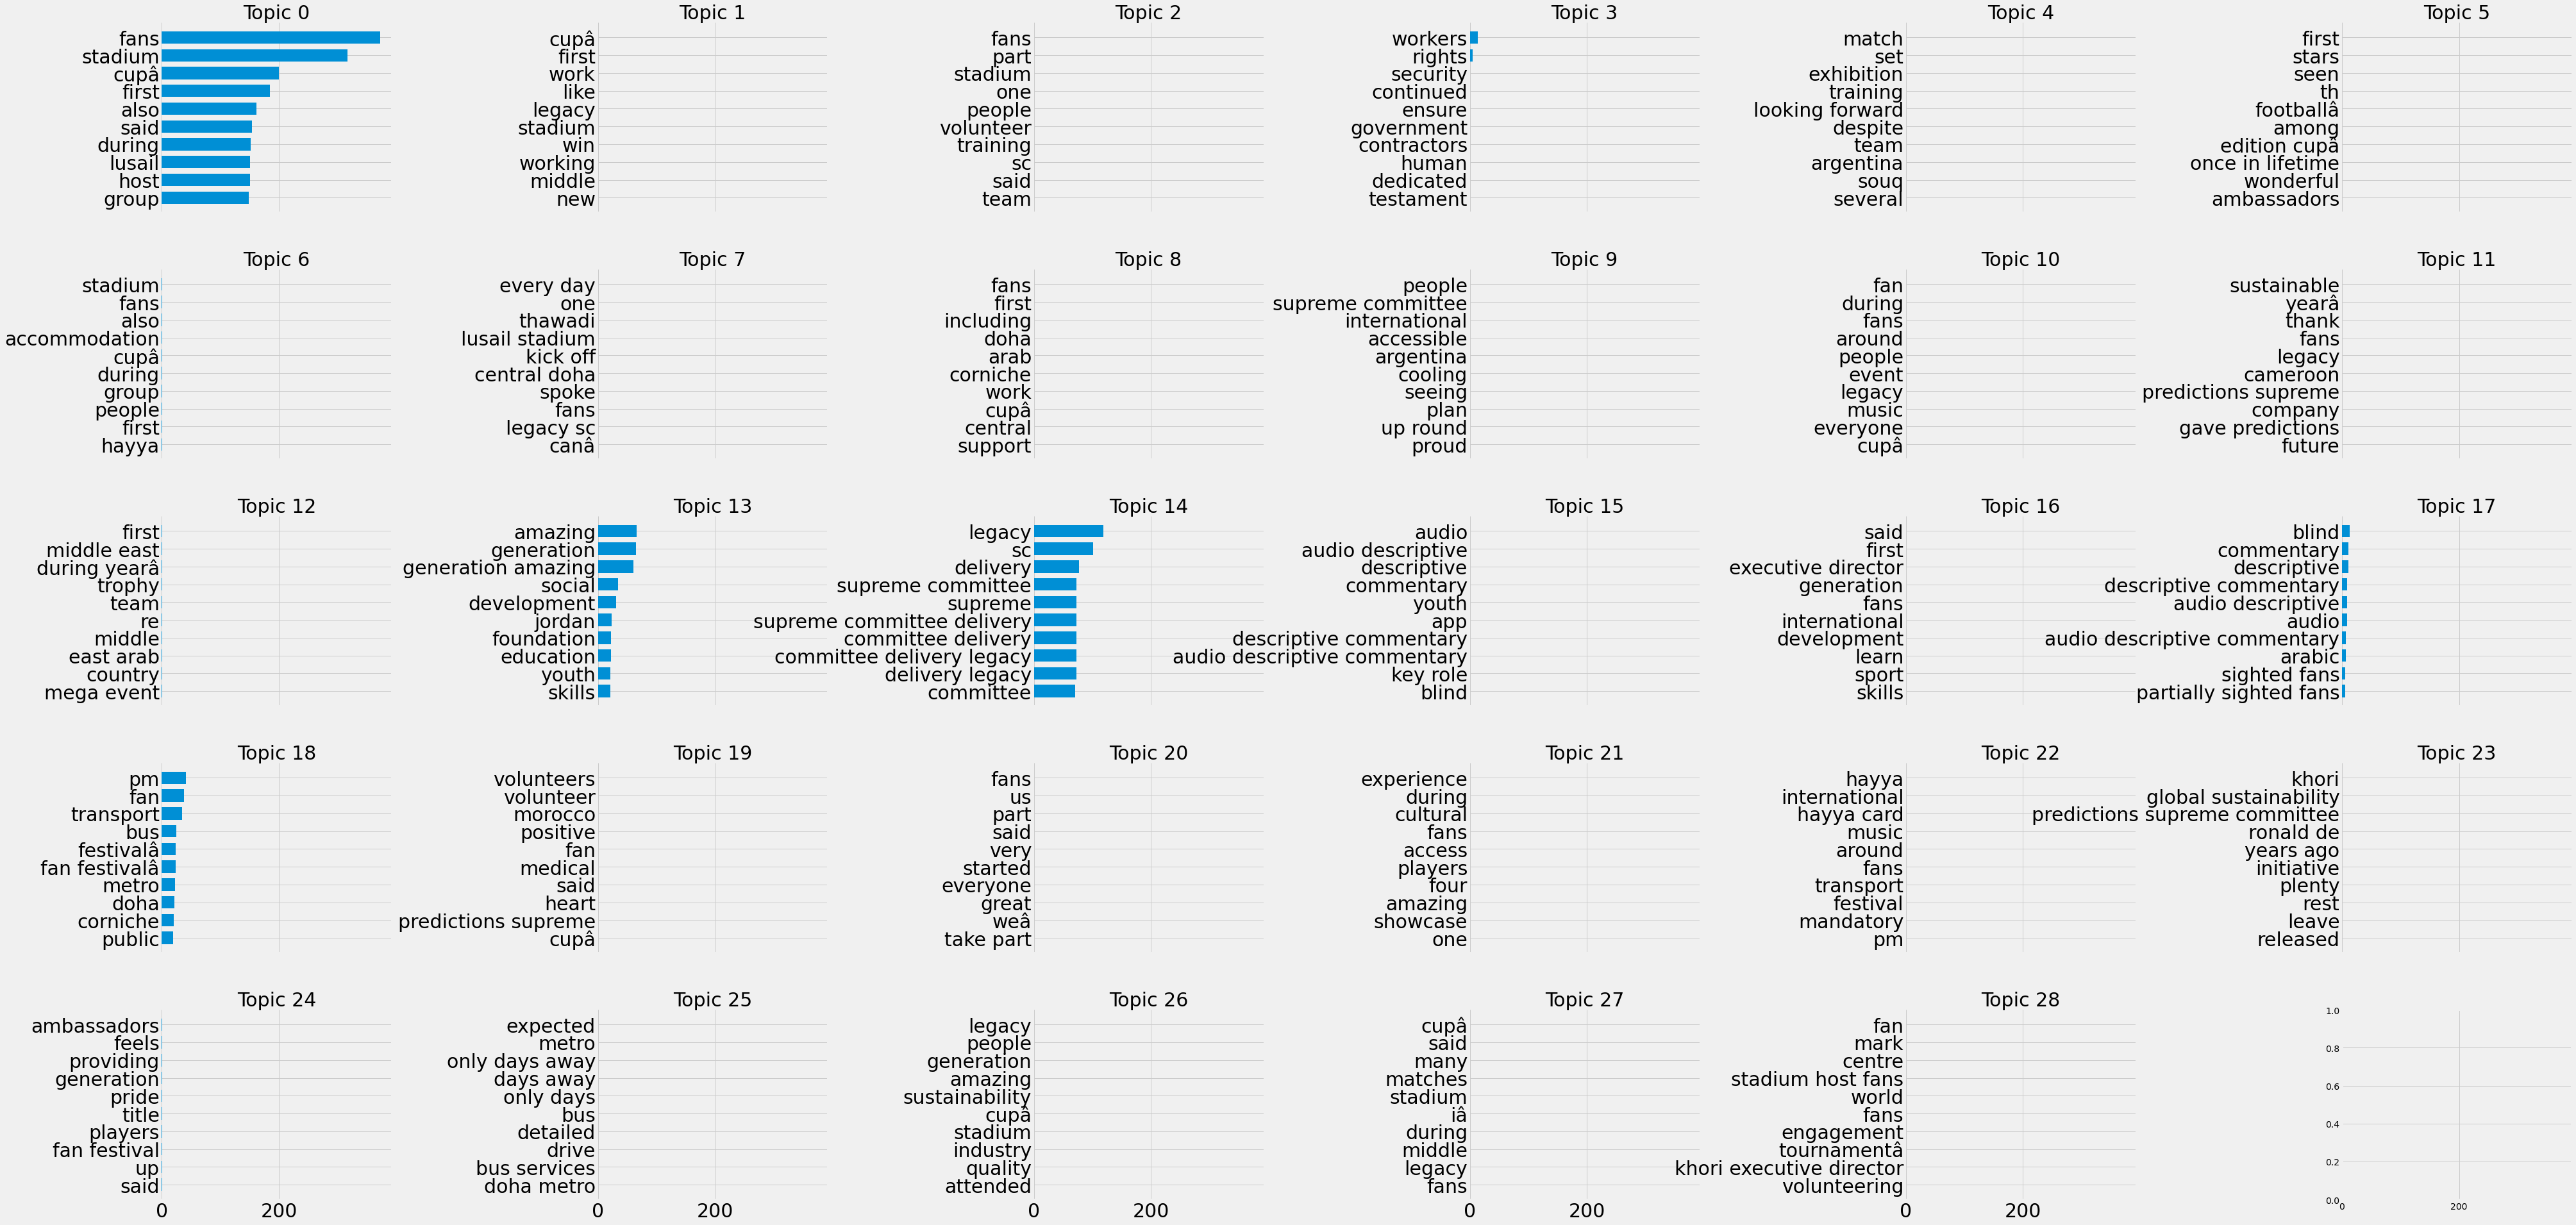

In [37]:
plot_top_words(lda, tf_feature_names, 10, title = '', subplotx = 5, subploty = 6)

In [45]:
def topic_by_index(model, feature_names, no_top_words, topic_index):
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx == topic_index):
            text = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
            wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
            plt.figure()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.show()

In [46]:
import re
tf_feature_names = [re.sub(' ', '_', x) for x in tf_feature_names]

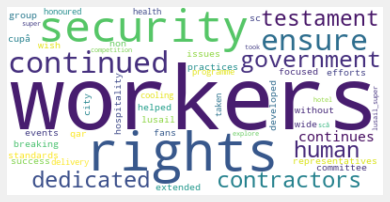

In [47]:
topic_by_index(lda, tf_feature_names, 50, 3)

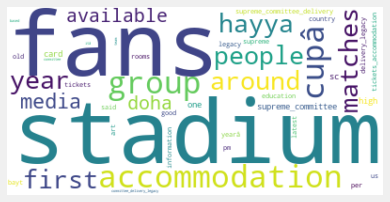

In [48]:
topic_by_index(lda, tf_feature_names, 50, 6)


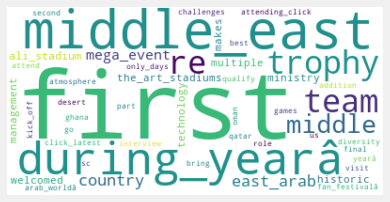

In [49]:
topic_by_index(lda, tf_feature_names, 50, 12)

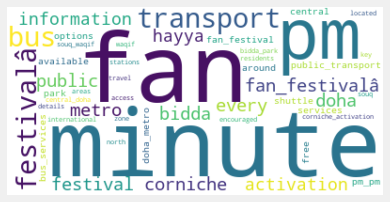

In [50]:
topic_by_index(lda, tf_feature_names, 50, 18)

In [51]:
lda = LatentDirichletAllocation(n_components = 29, # let us stay with 30, as that is what topic coherence initially recommended
                                doc_topic_prior = 0.05,
                                topic_word_prior = 0.001,
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 150,
                                random_state = 123)
lda.fit(tfidf) # TF-IDF now

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['event', 'available', 'fans', 'pm', 'we', 'also', 'tickets', 'people', 'added', 'opening_match']
Topic 1:  ['jordan', 'global_sustainability_assessment', 'recommend', 'human', 'khori_executive', 'thanks', 'generations', 'hamad_international', 'advice_would', 'generation_amazing']
Topic 2:  ['hayya', 'process', 'fans', 'benefits', 'help', 'series', 'sc', 'entry_permit', 'act_entry_permit', 'ticket']
Topic 3:  ['city', 'safe', 'group', 'senegal', 'wide', 'al', 'lusail', 'boost', 'committee', 'government']
Topic 4:  ['artists', 'lusail', 'hilal', 'fans', 'match', 'sc', 'super', 'rail', 'training', 'enjoyed']
Topic 5:  ['volunteer', 'volunteers', 'training', 'learning', 'edition_cupâ', 'public', 'seen', 'face', 'role', 'once_in_lifetime']
Topic 6:  ['growing', 'it', 'generate', 'visited', 'around', 'massive', 'everywhere', 'per', 'yearâ', 'successful']
Topic 7:  ['airport', 'overall', 'compact', 'hamad_international', 'one', 'previous', 'arriving', 'tournaments', 'water', 'susta

In [52]:
lda.perplexity(tfidf)

2513948.225780794

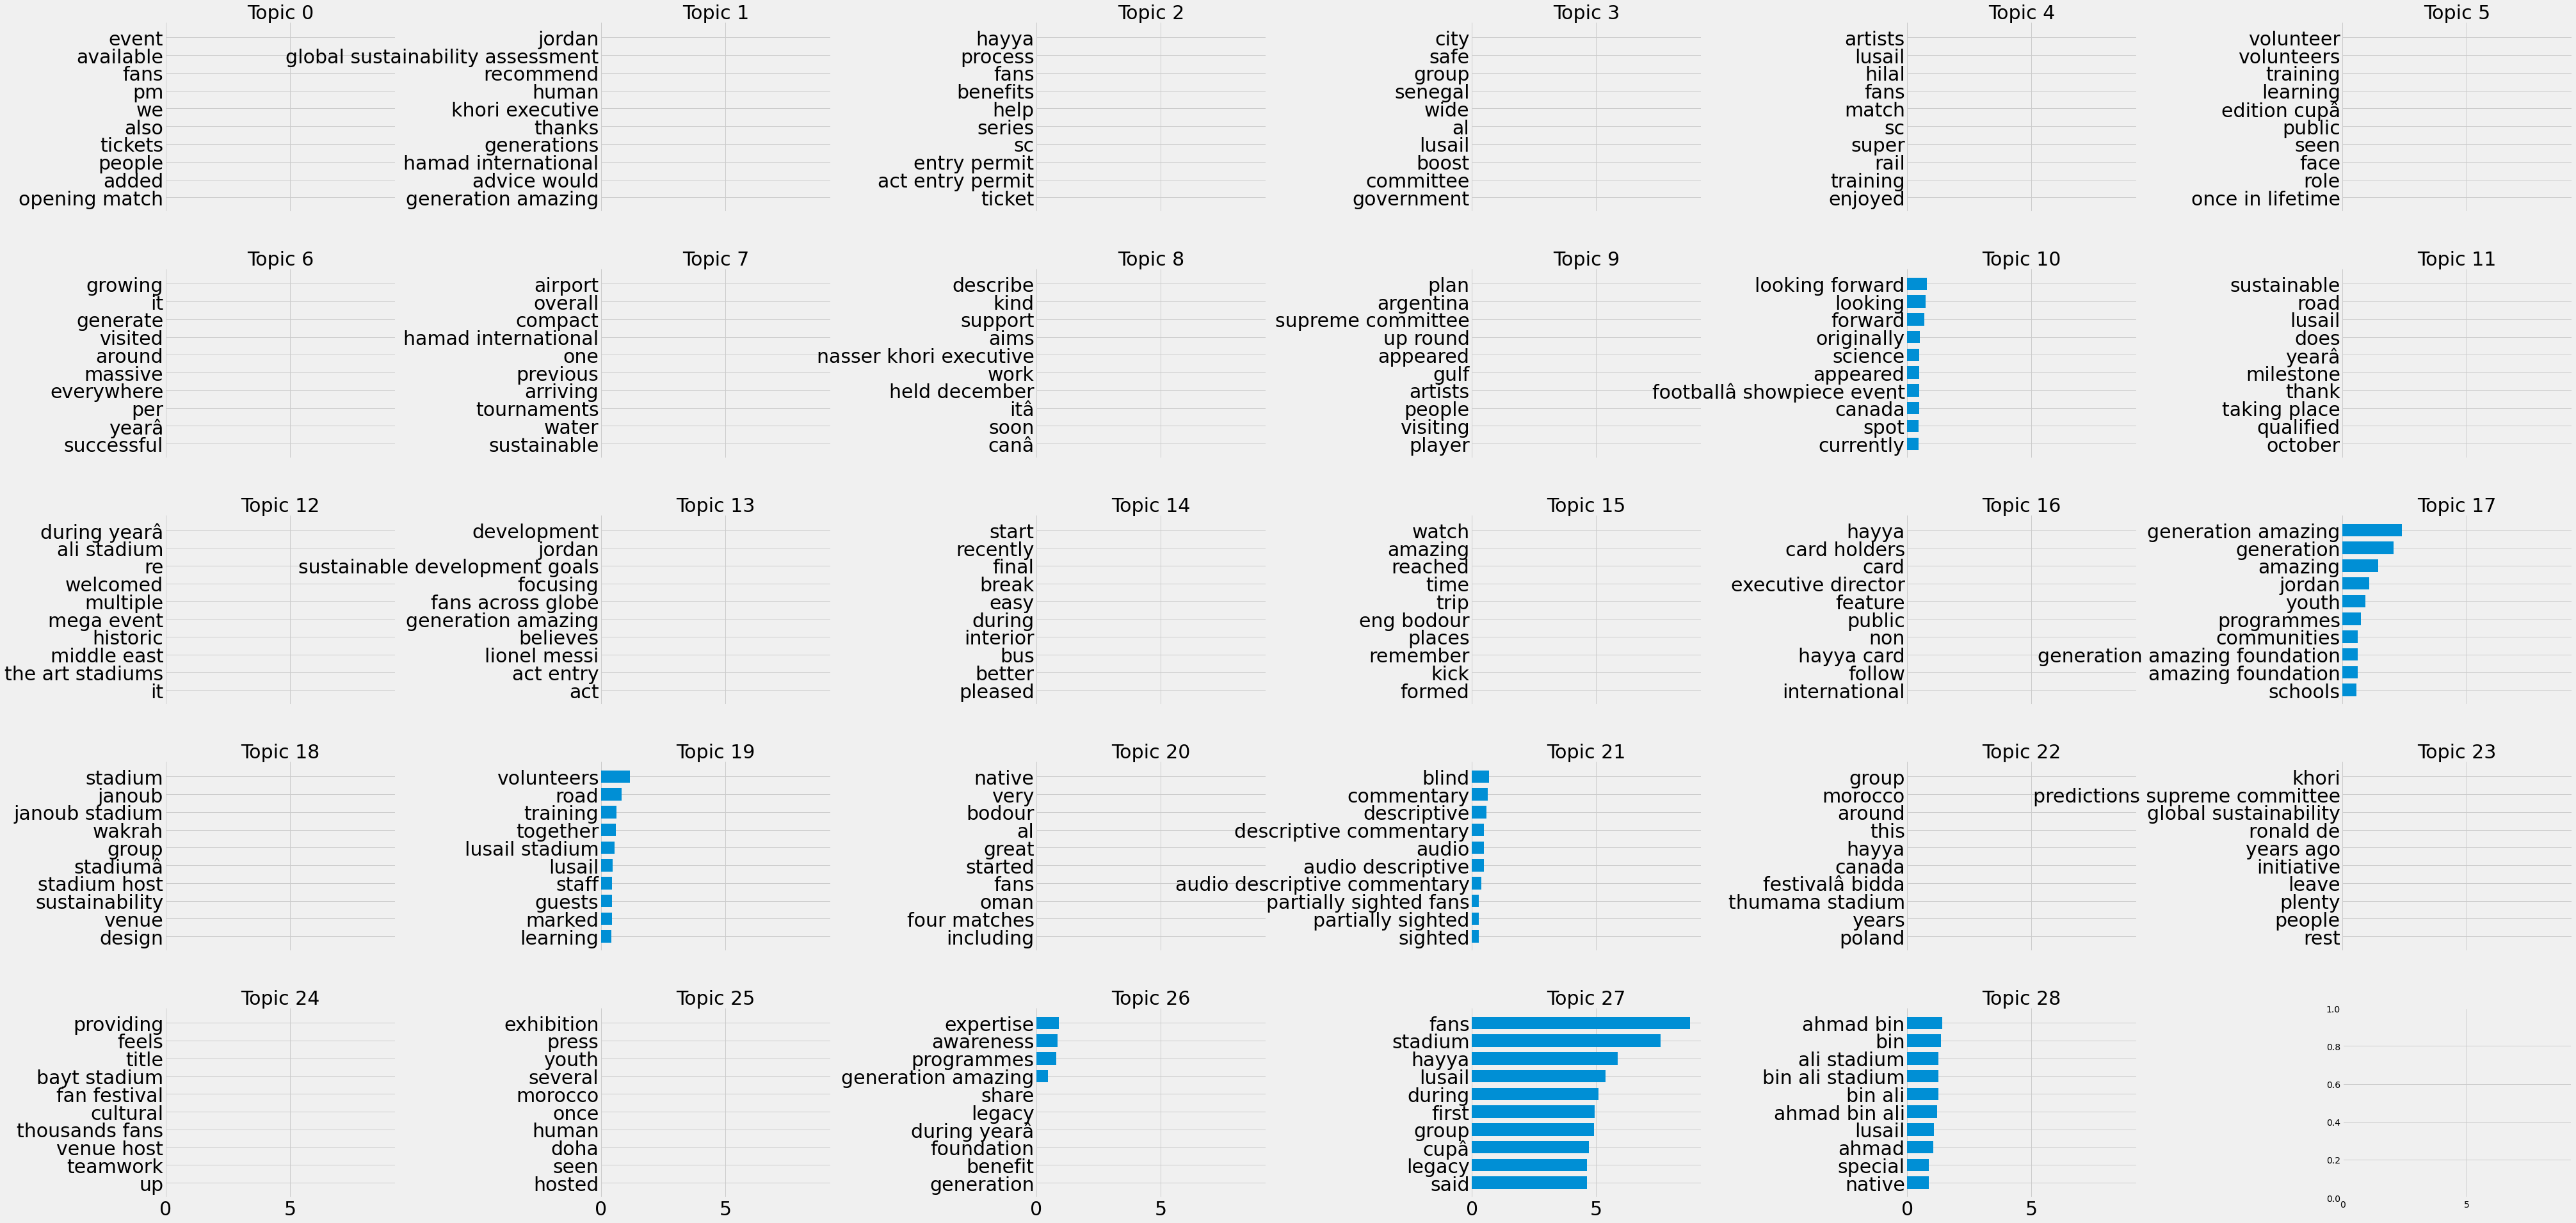

In [53]:
plot_top_words(lda, tfidf_feature_names, 10, title = '', subplotx = 5, subploty = 6)

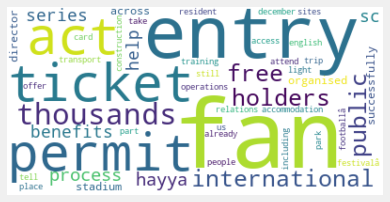

In [54]:
topic_by_index(lda, tfidf_feature_names, 50, 2)

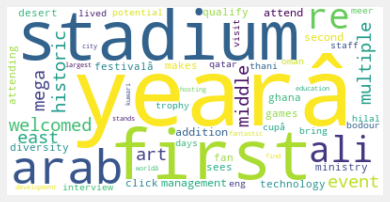

In [55]:
topic_by_index(lda, tfidf_feature_names, 50, 12)